In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ucitavanje
data = pd.read_csv('data_hw1_2025.csv', header=None)

x = data.iloc[:, :4]
y = data.iloc[:, 4]

In [3]:
# Podela na train i test
rng = np.random.RandomState(0)
zzz = rng.permutation(x.shape[0])

n_train = int(0.8 * x.shape[0])
train_ind = zzz[:n_train]
test_ind = zzz[n_train:]

x_train = x.iloc[train_ind]
y_train = y.iloc[train_ind]

x_test = x.iloc[test_ind]
y_test = y.iloc[test_ind]

In [4]:
test_ind

array([114, 151,  31, 166, 127, 176,  32, 142, 169, 147,  29,  99,  82,
        79, 115, 148, 193,  72,  77,  25, 165,  81, 188, 174, 190,  39,
        58, 140,  88,  70,  87,  36,  21,   9, 103,  67, 192, 117,  47,
       172])

In [5]:
x_test.loc[test_ind[0]]

0     0.76
1    -1.77
2    92.28
3     1.53
Name: 114, dtype: float64

In [6]:
# Standardizacija
sr_vr = x_train.mean()
std = x_train.std(ddof=0)

x_train_std = (x_train - sr_vr) / std
x_test_std = (x_test - sr_vr) / std

In [7]:
def root_mean_square(y_pred, y_true):
    y_pred = np.asarray(y_pred).reshape(-1)
    y_true = np.asarray(y_true).reshape(-1)
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [8]:
class LWLR:
    def __init__(self, x_train, y_train, tau):
        X = np.asarray(x_train)
        ones = np.ones((X.shape[0], 1))
        self.X = np.hstack([ones, X])
        self.y_train = np.asarray(y_train).reshape(-1)
        self.tau = tau
        
    def predict(self, x_new):
        x_new = np.asarray(x_new).reshape(1, -1)
        X_new = np.hstack([np.ones((1, 1)), x_new])
        diff = self.X - X_new
        weights = np.exp(-np.sum(diff**2, axis=1) / (2 * self.tau**2))
        W = np.diag(weights)
        theta = np.linalg.pinv(self.X.T @ W @ self.X) @ self.X.T @ W @ self.y_train
        y_pred = X_new @ theta
        return y_pred[0], theta
    
    def predict_vector(self, X_NEW):
        X_NEW = np.asarray(X_NEW)
        Y_pred = np.empty(X_NEW.shape[0])
        for i, x_new in enumerate(X_NEW):
            y_pred, _ = self.predict(x_new)
            Y_pred[i] = y_pred
        return Y_pred

In [9]:
# Trazenje tau unakrsnom validacijom
K = 5
taus = np.linspace(0.5, 2, 200)

train_scores = np.empty((taus.size, K))
val_scores = np.empty((taus.size, K))

for k in range(K):
    val_ind_k = train_ind[int(k*n_train/K):int((k+1)*n_train/K)]
    
    x_val_k = x_train_std.loc[val_ind_k]
    y_val_k = y_train.loc[val_ind_k]
    
    x_train_k = x_train_std.drop(index=val_ind_k)
    y_train_k = y_train.drop(index=val_ind_k)
    
    for i in range(taus.size):
        tau = taus[i]
        lwlr = LWLR(x_train_k, y_train_k, tau)
        
        y_pred = lwlr.predict_vector(x_val_k)
        val_scores[i][k] = root_mean_square(y_pred, y_val_k)
        
        y_pred = lwlr.predict_vector(x_train_k)
        train_scores[i][k] = root_mean_square(y_pred, y_train_k)
        
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

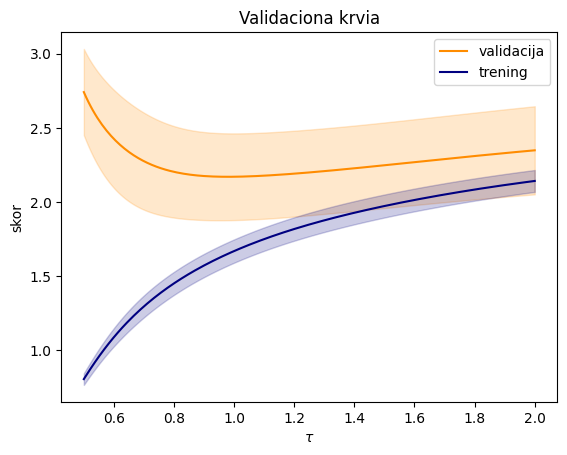

In [10]:
# Grafik
plt.title('Validaciona krvia')
plt.xlabel(rf'$\tau$')
plt.ylabel('skor')

plt.plot(taus, val_scores_mean, label='validacija', color='darkorange')
plt.fill_between(taus, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='darkorange')

plt.plot(taus, train_scores_mean, label='trening', color='navy')
plt.fill_between(taus, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='navy')

plt.legend(loc='best')
plt.show()

In [11]:
best_idx = np.argmin(val_scores_mean)
best_tau = taus[best_idx]
print('Najbolje tau:', best_tau)

lwlr_best = LWLR(x_train_std, y_train, best_tau)
y_test_pred = lwlr_best.predict_vector(x_test_std)
test_rmse = root_mean_square(y_test_pred, y_test)
print('Test RMSE:', test_rmse)

Najbolje tau: 0.9824120603015075
Test RMSE: 2.263800730153205


In [12]:
# Izgled hipoteze za jedna primer test skupa
x_0 = x_test_std.loc[test_ind[0]]
y_0 = y_test.loc[test_ind[0]]

y_0_pred, theta_0 = lwlr_best.predict(x_0)

print('RMSE_0:', root_mean_square(y_0_pred, y_0))
print(theta_0)

RMSE_0: 1.8456899530664712
[-0.35408032  2.80058669 -0.9555895   0.87459644  0.08608535]
